In [1]:
import pandas as pd
import numpy as np

In [2]:
from matplotlib import pyplot as plt

In [3]:
import requests
from bs4 import BeautifulSoup

In [4]:
import geopy
from geopy import geocoders
from geopy import distance

In [5]:
import random
import time

In [6]:
import seaborn as sns

In [7]:
from geopy.geocoders import Nominatim

In [8]:
import folium

In [9]:
desktop = 'c:/users/piyush/desktop/'

## Business Problem

**New Delhi** is the capital of **India**.

The city is home to many **multi-billion dollars start-ups** some of them being **Zomato, Mobikwik, Snapdeal, Dopspot**. Also famous for it’s **diverse food culture and large number of restaurants offering dozens of different cuisines**.

Since, the city falls under one of the most richest cities in India. People are willing to spend money on good food. Hence, there is abundant demand from people for good food.

But, there is also intense competition for existing restaurants to capture more consumers. 

### *The business problem* that we're interested in is to find the neighborhoods of Delhi that does not have much eatries around. Also, to sort those neighborhoods according to the price / square feet to find the cheapest locations to open new restaurants / eatries or any different kind of shops

### The main stake holders for this project will be Entrepreneurs or Restauranteurs looking to open shops in New Delhi. They will be able to access the competition of their rival restaurants and compare the competition with the prices of the neighborhood to make optimized decisions about which Neighborhood to choose in New Delhi to open a particular type of shop. 


## Data used for the project

The Datasets that will be used are:

    1. Delhi Neighborhood Data which have the neighborhood names and districts of the New Delhi**
<a href = 'https://en.wikipedia.org/wiki/Neighbourhoods_of_Delhi'>Wikipedia Source of neighborhood data</a>

    2. Delhi Neighborhood Price Data which contains the prices of different Delhi Neighborhoods
<a href = 'https://www.makaan.com/price-trends/property-rates-for-buy-in-delhi'>Prices of different Delhi Neighborhoods(https://makaan.com)</a>

Other sources used to get the geographic data and geocoding data are:
     1. Foursquare API to get the best venues for a given neighborhood
     2. HERE Developers API to get the geocoding data(Latitudes and Longitudes) of the above two data sets. 
     
<a href = 'https://developer.foursquare.com/'>Foursquare Developer API</a>

<a href = 'https://developer.here.com/'>HERE Developer API</a>

## How Data will be used to solve the problem

Wikipedia Page has Delhi's Neighborhood Data which is stored in different sections of the page. BeautifulSoup's scraping library will be used to get the of the diffferent section out and store it in a Pandas DataFrame.

On the other hand makaan.com website has stored data in a very complex format. There are multiple tables on the website and locating the appropriate tables and the contents in each Column could be tricky. BeautifulSoup's scraping library will be used for the same thing.

After we have the Data with the geocoding coordinates available, we'll be using the foursquare's geogrpahic data to get the best venue of the neighborhood.
We will be around half way into the project now.

But, we'll also need a way to figure out how to match the neighborhood data of wikipedia page to the Neighborhood price data of makaan.com since all the neighborhood won't have the same name and there may be lots of neighborhoods who don't match up. 
To solve the above problem, we'll use the geopy's distance.distance function which calculates the distance between two geographical coordinates. We'll first search for the neighborhood in the price data and in case it doesn't exist(or has a different name) we'll instead calculate the distance of each coordinate in the price data to the neighborhood's coordinate and assign the price of the neighborhood which has passed some minimum threshold(for example if the neighborhood's coordinates is within 100 meters of the Price data's current row). 

These are the main problems that we will try to tackle with the data that we have. 

### Objective

1. The objective of the project is to find the locations in the market where a particular type of business is present


A. For that, we need to find the top venues of given neighborhood

First we need to find the neighborhoods in delhi

Next, we'll use foursquare endpoint explore to find the top 50 locations for each neighborhood

Next we'll group by categories

Then we'll find the top n(10 in this case) location for each neighborhood

B. Next, we'll take input of what kind of business a client / person wants to open

We'll return those areas where there is some kind of market 

3. We'll also try to get the real estate prices of different areas in New Delhi


Let's get started

In [10]:
source = 'https://en.wikipedia.org/wiki/Neighbourhoods_of_Delhi'

In [11]:
text = requests.get(source).text

In [12]:
soup = BeautifulSoup(text, 'lxml')

In [13]:
soup = soup.body

In [14]:
#sub_t.find('a').replaceWith('whatever')

### Getting the district names

In [15]:
districts = []
for item in soup.find_all('span', class_ = 'mw-headline'):
    districts.append(item.text)
    
districts = districts[:-3]
districts

['North West Delhi',
 'North Delhi',
 'North East Delhi',
 'Central Delhi',
 'New Delhi',
 'East Delhi',
 'South Delhi',
 'South West Delhi',
 'West Delhi']

### Getting information about the sub-districts and binding it to soup_subd

In [16]:
soup_subd = soup.find_all('ul')[1:10]

In [17]:
soup_subd[0]

<ul><li>Adarsh Nagar</li>
<li><a href="/wiki/Ashok_Vihar" title="Ashok Vihar">Ashok Vihar</a></li>
<li>Azadpur</li>
<li><a href="/wiki/Bawana" title="Bawana">Bawana</a></li>
<li><a href="/wiki/Begum_Pur" title="Begum Pur">Begum Pur</a></li>
<li><a href="/wiki/Dhaka_(village)" title="Dhaka (village)">Dhaka</a></li>
<li>Jahangirpuri</li>
<li><a href="/wiki/Karala,_Delhi" title="Karala, Delhi">Karala</a></li>
<li><a href="/wiki/Keshav_Puram" title="Keshav Puram">Keshav Puram</a></li>
<li><a href="/wiki/Kingsway_Camp" title="Kingsway Camp">Kingsway Camp</a></li>
<li>Kohat Enclave</li>
<li><a href="/wiki/Model_Town_(Delhi)" title="Model Town (Delhi)">Model Town</a></li>
<li><a href="/wiki/Narela" title="Narela">Narela</a></li>
<li><a href="/wiki/Pitam_Pura" title="Pitam Pura">Pitam Pura</a></li>
<li><a href="/wiki/Rani_Bagh,_Delhi" title="Rani Bagh, Delhi">Rani Bagh</a></li>
<li>Rithala</li>
<li><a class="mw-redirect" href="/wiki/Rohini_Sub_City" title="Rohini Sub City">Rohini Sub City</a><

### Replacing all the a tags with their text

In [18]:
for subdistricts in soup_subd:
    for a in subdistricts.find_all('a'):
        text = a.text
        a.replaceWith(text)

### soup_subd now has all of the districts information

In [20]:
neigh_dict = {}
for district in soup_subd[:3]:
    for subdistrict in district.find_all('li'):
        print(subdistrict.text)
    print('--------------')

Adarsh Nagar
Ashok Vihar
Azadpur
Bawana
Begum Pur
Dhaka
Jahangirpuri
Karala
Keshav Puram
Kingsway Camp
Kohat Enclave
Model Town
Narela
Pitam Pura
Rani Bagh
Rithala
Rohini Sub City
Shalimar Bagh
--------------
Shakti Nagar
Bara Hindu Rao
Chandni Chowk
Chawri Bazaar
Civil Lines
Dariba Kalan
Ghantewala
Gulabi Bagh
Kamla Nagar
Kashmiri Gate
Kotwali
Lahori Gate
Nehru Vihar
Paharganj
Pratap Nagar
Pul Bangash
Roshanara Bagh
Sadar Bazaar
Sangam Vihar
Sant Nagar
Sarai Kale Khan
Sarai Rohilla
Shakti Nagar
Shastri Nagar
Tees Hazari
Timarpur
Wazirabad
--------------
Babarpur
Dilshad Garden
Kabir Nagar
Mandoli
Maujpur
Nand Nagri
Naveen Shahdara
New Usmanpur
Sadatpur
Shahdara
Sonia Vihar
Shastri Park
Yamuna Vihar
--------------


In [21]:
neigh_dict = {}

if len(soup_subd) == len(districts):
    for district, subdistricts in zip(districts, soup_subd):
        subdistricts_arr = []
        for subdistrict in subdistricts.find_all('li'):
            subdistricts_arr.append(subdistrict.text)
            
        neigh_dict[district] = subdistricts_arr
else:
    print('The length of districts and soup_subd are not equal.. Something is wrong')

### Here's the neighborhoods of North West Delhi

In [25]:
neigh_dict['North West Delhi']

['Adarsh Nagar',
 'Ashok Vihar',
 'Azadpur',
 'Bawana',
 'Begum Pur',
 'Dhaka',
 'Jahangirpuri',
 'Karala',
 'Keshav Puram',
 'Kingsway Camp',
 'Kohat Enclave',
 'Model Town',
 'Narela',
 'Pitam Pura',
 'Rani Bagh',
 'Rithala',
 'Rohini Sub City',
 'Shalimar Bagh']

### Now, we have the neighborhooods and district names of New Delhi, India. Let's make a pandas dataframe

In [26]:
# Storing dictionary data(Neighborhood names) in numpy array first

#Total number of neighborhoods
total = 0
for key in neigh_dict:
    total += len(neigh_dict[key])
    
    
data = np.full(fill_value = '', dtype = '<U50', shape = (total, 2))
i = 0
for district in neigh_dict:
    subd_arr = neigh_dict[district]
    for subd in subd_arr:
        data[i] = [subd, district]
        i += 1
        

In [27]:
neigh_df = pd.DataFrame(data)
neigh_df.columns = ['Neighborhoods', 'Districts']
neigh_df.head()

,Neighborhoods,Districts
0,Adarsh Nagar,North West Delhi
1,Ashok Vihar,North West Delhi
2,Azadpur,North West Delhi
3,Bawana,North West Delhi
4,Begum Pur,North West Delhi


### Using here developer credentials to get access to geolocation api

In [28]:
app_id = 'ENTER YOUR APP ID HERE'
app_code = 'ENTER YOUR HERE DEVELOPER\'S APP CODE HERE'
base_uri = 'https://geocoder.api.here.com/6.2/geocode.json'
gen = 9

In [29]:
def getUrl(query, app_id = app_id, app_code = app_code, gen = gen):
    base_uri = 'https://geocoder.api.here.com/6.2/geocode.json'
    
    #Replacing the spaces in the search query with %20
    query = query.replace(' ', '%20')
    url = f'{base_uri}?searchtext={query}&app_id={app_id}&app_code={app_code}&gen={gen}'
    
    return url

In [30]:
### Making a function for getting geodata(geocoding) using here credentials

def get_geocode(query, app_id = app_id, app_code = app_code, gen = gen):
    '''
    input :
    
    query-> The search query of a place. For example
    
    >>> get_geocode('New York, Usa', app_id = #app_id, app_code = #app_code, gen = #gen)
    
    Returns the location coordinates of New York USA
    
    '''
    
    
    url = getUrl(query)
    
    tries = 0
    while tries < 3:
        try:
            json = requests.get(url).json()
            if type(json) != type(None):
                break
            else:
                tries +=1
        except:
            tries += 1
            
    
    try:
        if json['Response']['View'] == []:
            return [np.nan, np.nan]
        
        else:
            lat_lng_dict = json['Response']['View'][0]['Result'][0]['Location']['NavigationPosition'][0]
            lat = lat_lng_dict['Latitude']
            lng = lat_lng_dict['Longitude']
            
    except:
        return [np.nan, np.nan]

    return lat, lng

In [31]:
#This cell gets the coordinates(latitudes and longitudes) of the neighborhoods in the data frame neigh_df using here
#deverlopers api and then adds it in the coordinates_arr


#This cell calls the here's geocode function, run this only if important

#>>>Cell Start<<<
# coordinates_arr = np.zeros(shape = (len(neigh_df), 2))

# for i in range(len(neigh_df)):
#     row = neigh_df.loc[i]
#     query = row[0] + ', ' + row[1]
#     coordinates = get_geocode(query)
#     coordinates_arr[i] = coordinates
    
#     if i % 10 == 0:
#         print(i + 1, 'Neighborhoods Geocoders processed')

### Now, we have all the latitude and longitude values. We now need to add it in the data frame

In [32]:
# neigh_df['Latitudes'] = coordinates_arr[:, 0]
# neigh_df['Longitudes'] = coordinates_arr[:, 1]

In [33]:
#Saving the current data frame to a local directory
#neigh_df.to_csv('c:/users/piyush/desktop/extras/delhi neighborhoods/neigh_df.csv')

In [34]:
neigh_df = pd.read_csv('c:/users/piyush/desktop/extras/delhi neighborhoods/df_neigh.csv', index_col = 0)

In [35]:
neigh_df.head()

,Neighborhoods,Districts,Latitudes,Longitudes
0,Adarsh Nagar,North West Delhi,28.72036,77.17264
1,Ashok Vihar,North West Delhi,28.69038,77.17610
2,Azadpur,North West Delhi,28.71243,77.17305
3,Bawana,North West Delhi,28.79767,77.04522
4,Begum Pur,North West Delhi,28.73262,77.05213


### Removing duplicate neighborhoods

In [36]:
duplicates = neigh_df[neigh_df['Neighborhoods'].duplicated(keep = 'first')].Neighborhoods.values

In [37]:
duplicates

array(['Shakti Nagar', 'Chandni Chowk', 'Bara Hindu Rao', 'Paharganj',
       'Sadar Bazaar', 'Shastri Nagar', 'Shahdara', 'Sangam Vihar',
       'Sarojini Nagar', 'Dhaula Kuan'], dtype=object)

### Checking the distance between each dupliacate neighborhood. If distance is small, then removing a duplicate

In [38]:
#Checking the distance between the duplicates. If the distance is greater than 500 metres, duplicates will be kept, otherwise appended
# to duplicates_redundant. 
duplicates_redundant = []
for duplicate in duplicates:
    dup_df = neigh_df[neigh_df.Neighborhoods == duplicate]
    if dup_df.shape[0] == 2:
        row1 = dup_df.iloc[0]
        coord1 = (row1['Latitudes'], row1['Longitudes'])
        row2 = dup_df.iloc[1]
        coord2 = (row2['Latitudes'], row2['Longitudes'])
        distance_ = distance.distance(coord1, coord2).meters
        if distance_ >= 500:
            continue
        else:
            duplicates_redundant.append(duplicate)

In [39]:
#Removing those neighborhoods which are too close
t = ~neigh_df.loc[neigh_df.Neighborhoods.isin(duplicates_redundant)].duplicated(keep = 'first')
for index in t.index:
    if t[index] == True:
        neigh_df = neigh_df.drop(index)

In [40]:
neigh_df = neigh_df.reset_index(drop = True)

### Plotting the neighborhoods on folium maps

In [41]:
geolocator = Nominatim(user_agent = 'my_app')
location = geolocator.geocode('New Delhi, India')
location = (location.latitude, location.longitude)

In [42]:
delhi_map = folium.Map(location = location, zoom_start = 10)
colors = sns.color_palette(palette = 'bright', n_colors = 9).as_hex()
unique_districts = neigh_df.Districts.unique().tolist()

for i in range(len(neigh_df)):
    row = neigh_df.iloc[i]
    popup = row['Neighborhoods'] + ', ' + row['Districts']
    coordinates = (row.Latitudes, row.Longitudes)
    
    #Using try statement because there are some coordinates which have np.nan values. Try statement will ignore these
    try:
        color_index = unique_districts.index(row['Districts'])
        color = colors[color_index]
        folium.CircleMarker(location = coordinates, popup = popup, tooltip = popup, color = color).add_to(delhi_map)
    except:
        print('Invalid Geolocation coordinates')
        pass

Invalid Geolocation coordinates
Invalid Geolocation coordinates
Invalid Geolocation coordinates
Invalid Geolocation coordinates
Invalid Geolocation coordinates


In [43]:
delhi_map

#### Using Foursquare api to get the top venues in each neighborhood

In [44]:
delhi_map.save(desktop + 'delhi_map2.html')

In [45]:
CLIENT_ID = 'Enter your foursquare CLIENT_ID here'
CLIENT_SECRET = 'Enter your foursquare\'s CLIENT SECRET here'
VERSION = '20180605'


In [46]:
foursquare_explore_uri = 'https://api.foursquare.com/v2/venues/explore'

In [47]:
r = neigh_df.loc[0]
ll = str(r['Latitudes']) +',' + str(r['Longitudes'])

In [48]:
params = {'client_id' : CLIENT_ID, 'client_secret' : CLIENT_SECRET, 'v' : '20180605', 'll' : ll, 'limit' : '50', 'radius' : '4000'
}

In [49]:
def get_foursquare_explore_url(lat, lng, limit = 50, radius = 5000, client_id = CLIENT_ID, client_secret = CLIENT_SECRET, version = VERSION):
    foursquare_explore_uri = 'https://api.foursquare.com/v2/venues/explore?'
    url = f'{foursquare_explore_uri}client_id={client_id}&client_secret={client_secret}&v={version}&ll={lat},{lng}&limit={limit}\
&radius={radius}'
    
    return url

In [50]:
def get_neighborhoods_venues(array_neighborhoods, array_latitudes, array_longitudes, limit = 50, radius = 3000):
    if not (len(array_neighborhoods) == len(array_latitudes) and len(array_latitudes) == len(array_longitudes)):
        raise Exception('Length of inputs are not same')
        
    venues_list = []
    
    for lat_neigh, lng_neigh, name_neigh, i  in zip(array_latitudes, array_longitudes, array_neighborhoods, range(len(array_neighborhoods))):
        url = get_foursquare_explore_url(lat_neigh, lng_neigh, limit = limit, radius = radius)

        venues_dic = requests.get(url).json()
        
        # checking if request is good, doesn't return error
        
        if venues_dic['meta']['code'] == 200:
            venues_dic = venues_dic['response']['groups'][0]['items']
            error = False
            
            
        else:
            print('Can\'t add the neighborhood {} due to request error'.format(name_neigh))
            error = True
        # Using the for loop again to iterate through the venues in venues_dic
        if not error:
            for venues in venues_dic:
                venue_name = venues['venue']['name']
                venue_id = venues['venue']['id']
                venue_cat = venues['venue']['categories'][0]['name']
                venue_lat = venues['venue']['location']['lat']
                venue_lng = venues['venue']['location']['lng']
                tup = (venue_name, venue_id, venue_cat, venue_lat, venue_lng,  name_neigh, lat_neigh, lng_neigh)
                venues_list.append(tup)
            print(f'Neighborhood {name_neigh} added. {i + 1} Neighborhoods Processed')
        error = False
        
    #Now, each inner tuple of venue has a venue in it, let's convert it in a 
    #data frame and name the columns and get done with it...
    cols = ['VenueNames', 'VenueIds', 'VenueCategories', 'VenueLatitudes', 'VenueLongitudes', 'NeighborhoodNames', 'NeighborhoodLatitudes', 'NeighborhoodLongitudes']
    df = pd.DataFrame(venues_list)
    df.columns = cols
        
    return df

In [51]:
#This cell calls the function get_neighorhood_venues which further uses the foursquare api to get the geographical data
#venues_df = get_neighborhoods_venues(neigh_df['Neighborhoods'], neigh_df['Latitudes'], neigh_df['Longitudes'])

In [52]:
### Saving the venues_df data frame locally
#venues_df.to_csv(desktop + 'extras/delhi neighborhoods/venues_df.csv')

In [53]:
#Reading the venues_df saved locally
venues_df = pd.read_csv(desktop + 'extras/delhi neighborhoods/venues_df.csv', index_col = 0)

In [54]:
print(venues_df.shape)
venues_df.head()

(6470, 8)


,VenueNames,VenueIds,VenueCategories,VenueLatitudes,VenueLongitudes,NeighborhoodNames,NeighborhoodLatitudes,NeighborhoodLongitudes
0,Shalimar bagh club,50476c99e4b0fb33813c9e2b,Indian Restaurant,28.711882,77.157933,Adarsh Nagar,28.72036,77.17264
1,Ever Bake,4be2cf842fc7d13a216f083a,Bakery,28.706419,77.162607,Adarsh Nagar,28.72036,77.17264
2,"DT Cinemas, City Centre",4b8a46d7f964a520b66632e3,Multiplex,28.703045,77.158189,Adarsh Nagar,28.72036,77.17264
3,Arjun Pao Bhaji,4bfd427dbf6576b036f7acb8,Indian Restaurant,28.708468,77.184963,Adarsh Nagar,28.72036,77.17264
4,Bellagio,4d7ca74b136bf04db8ef628d,Asian Restaurant,28.696361,77.180021,Adarsh Nagar,28.72036,77.17264


In [55]:
venues_df.shape

(6470, 8)

In [56]:
venues_df.NeighborhoodNames.value_counts().sort_values(ascending = False).head(7)

Sarojini Nagar        100
Shastri Nagar          80
Sadar Bazaar           74
Vasant Kunj            50
Nehru Place            50
Safdarjung Enclave     50
Sundar Nagar[1]        50
Name: NeighborhoodNames, dtype: int64

In [57]:
#Getting dummies for venue_category
dummy_df = pd.get_dummies(venues_df, columns = ['VenueCategories'], prefix = '', prefix_sep = '')

In [58]:
grouped_df = dummy_df.groupby('NeighborhoodNames', as_index = False).sum()

In [59]:
grouped_df.head()

,NeighborhoodNames,VenueLatitudes,VenueLongitudes,NeighborhoodLatitudes,NeighborhoodLongitudes,ATM,Accessories Store,Airport Lounge,American Restaurant,Arcade,...,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Yoga Studio
0,Adarsh Nagar,660.257651,1774.988566,660.56828,1774.97072,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Alaknanda,1426.922866,3862.365711,1426.28400,3862.66250,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,Anand Vihar,1432.371019,3865.853783,1432.67850,3865.68700,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
3,Ashok Nagar,1431.988987,3855.202051,1431.73100,3855.09050,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Ashok Vihar,1434.686099,3858.959144,1434.51900,3858.80500,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
cols = ['VenueLatitudes', 'VenueLongitudes', 'NeighborhoodLatitudes', 'NeighborhoodLongitudes']
flag = True
for col in cols:
    if not col in grouped_df.columns.tolist():
        flag = False
        
if flag:
    grouped_df = grouped_df.drop(cols, axis = 1)

In [61]:
def get_top_n_venues(df_grouped, n_venues, postal_code_col_name):
    
    
    '''
    
    
    '''
    
#     #making a  numpy  array  with rows = df_grouped and cols = n_venues + 1, 1 extra for the postal_code
#     top_n_venues_arr = np.zeros(shape = (len(df_grouped), n_venues + 1))
    
    top_n_venues_arr = []
    num_cat_groupby_arr = np.zeros(shape = (len(df_grouped), n_venues))
    
    if not postal_code_col_name in df_grouped.columns:
        raise Exception('postal_code_col_name is not found in the columns, provide the correct postal_code column name')
        
    for i in range(len(df_grouped)):
        # Series object having index as col names and values as row values
        row = df_grouped.iloc[i]
        
        # Binding the postal code of df to postal_code
        postal_code = row[postal_code_col_name]
        #Removing the postal_code since can't perform sort_values on categorical data, so making sure only category type
        # of venues are available
        row = row.drop(postal_code_col_name)
        
        try:
            top_n_venues = row.sort_values(ascending = False)[:n_venues].index.tolist()
            #The below binding has number of venues in each category of groupby. If there are 7 same categories in
            #postal code, it represents 7
                
            num_cat_groupby_arr[i] = row.sort_values(ascending = False)[:n_venues].values
        except:
            top_n_venues = np.full(shape = n_venues, fill_value = np.nan)
            num_cat_groupby_arr[i] = np.full(shape = n_venues, fill_value = np.nan)
            
        # Row of top_n_venues which have postal code and top n venues
        top_n_venues_row = (postal_code, ) + tuple(top_n_venues)
        #Appending the row in a 2-d numpy array, each index representing a row and inner list scrolling through cols
    
        top_n_venues_arr.append(top_n_venues_row)
        
    df = pd.DataFrame(top_n_venues_arr)
    cols = [postal_code_col_name] + [str(i) + '_venue' for i in range(1, n_venues + 1)]
    df.columns = cols
    
    #Adding the num_venues_groupby_arr
    df['Num_Categories'] = num_cat_groupby_arr.tolist()
    
    return df
        

In [62]:
top_venues_df = get_top_n_venues(grouped_df, 10, 'NeighborhoodNames')

In [63]:
top_venues_df.head()

,NeighborhoodNames,1_venue,2_venue,3_venue,4_venue,5_venue,6_venue,7_venue,8_venue,9_venue,10_venue,Num_Categories
0,Adarsh Nagar,Indian Restaurant,Coffee Shop,Convenience Store,Sandwich Place,Snack Place,Hotel,Light Rail Station,Golf Course,Fast Food Restaurant,Multiplex,"[3.0, 3.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,Alaknanda,Restaurant,Coffee Shop,Sandwich Place,Market,Indian Restaurant,Chinese Restaurant,Hotel,Italian Restaurant,Pizza Place,Fast Food Restaurant,"[5.0, 4.0, 4.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, ..."
2,Anand Vihar,Pizza Place,Café,Hotel,Multiplex,Park,Indian Restaurant,Fast Food Restaurant,Movie Theater,Department Store,Shop & Service,"[7.0, 4.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 1.0, ..."
3,Ashok Nagar,Café,Indian Restaurant,Pizza Place,Coffee Shop,Donut Shop,BBQ Joint,Fast Food Restaurant,Clothing Store,Shopping Mall,Restaurant,"[5.0, 5.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 2.0, ..."
4,Ashok Vihar,Coffee Shop,Pizza Place,Indian Restaurant,Fast Food Restaurant,Sandwich Place,Snack Place,Breakfast Spot,Bakery,Café,Donut Shop,"[8.0, 6.0, 6.0, 5.0, 3.0, 3.0, 2.0, 2.0, 2.0, ..."


### Getting the prices of Neighborhoods using web scraping

In [64]:
url = 'https://www.makaan.com/price-trends/property-rates-for-buy-in-delhi?page='

In [65]:
response = requests.get(url + '1')

In [66]:
source = response.text

In [67]:
bs = BeautifulSoup(source, 'lxml')

In [68]:
response = requests.get(url + '1')
source = response.text
bs = BeautifulSoup(source, 'lxml')

In [69]:
def get_neigh_price(url_makaandotcom):
    '''
    Input: URL of Makaan.com with tabular data information of house prices
    Output: Returns a numpy error of dimension (num, 2). With the 2nd dimension having data about the neighborhood name
    and price
    
    '''
    tries = 0
    while tries < 5:
        try:
            response = requests.get(url_makaandotcom)
            error = False
            break
        except:
            tries += 1
            error = True
    if not error and type(response) != type(None):
        source = response.text
        
    elif error:
        raise Exception('Unable to connect to the url after 5 tries')
        
    
    bs = BeautifulSoup(source, 'lxml')
    
    try:
        #Containing table headers and data
        data = bs.find_all('table')[0]
        
        #Containing only the relevant neighborhood data, each index in the list represents a neighborhood row
        relevant_data = data.find_all('tr')[2:]
        
        #Array of dimension (length, 2) having info about neigh name and price
        array = np.full(shape = (len(relevant_data), 2), dtype = '<U30', fill_value = np.nan)
        
        
        for row_data, i in zip(relevant_data, range(len(relevant_data))):
            try:
                info_list = row_data.find_all('td')
                neigh_name_info = info_list[0]
                
                #Getting neighborhood name
                if neigh_name_info.span['itemprop'] == 'name':
                    neigh_name = neigh_name_info.text
                
                else:
                    neigh_name = np.nan
                
                
                neigh_price = info_list[2].text
                
                
                
                
                
                #Adding the neighborhood name and neighborhood price to the numpy array
                array[i] = (neigh_name, neigh_price)
                
            except:
                neigh_price = np.nan
                neigh_name = np.nan  
                
        
    except:
        raise Exception('Scraper unable to fetch the Data Properly.')
    
    
    
    #Cleaning the price data, it's of the form 'price / sqft'
    #Also, null prices have value '-' in  it, so replacing those values with np.nan
    for i in range(len(array)):
        neigh_name = array[i][0]
        price_unclean = array[i][1]
        array[i] = (neigh_name, price_unclean.strip().split('/')[0].strip().replace(',', ''))
        if array[i][1] == '-':
            array[i] = (neigh_name, np.nan)

        
    return array

In [70]:
# ##This cell runs the scraper and scraps the 55 pages of the website makaan.com. Also pauses the program for .5 seconds after each page scraped
# ##Creating an empty data frame

# neigh_price_df = pd.DataFrame(columns = ['Neighborhoods', 'Latitudes', 'Longitudes', 'Prices(sqft)'])


# # Scraping the prices of neighborhoods for the first 10 pages of the website
# for i in range(1, 56):
#     page_url = url + str(i)
#     neigh_price = get_neigh_price(page_url)
#     for price_info in neigh_price:
#         neigh_price_df = neigh_price_df.append({'Neighborhoods' : price_info[0], 'Prices(sqft)' : price_info[1]}, ignore_index = True)
#     #Pausing the program for .5 seconds
#     print(i, 'Pages Scraped')
#     time.sleep(.5)
    

In [71]:
## Removing all the rows which don't have any prices

In [72]:
#Saving neigh_price_df locally on machine

#neigh_price_df.to_csv(desktop + 'extras/delhi neighborhoods/neigh_price_df.csv')

In [73]:
# Reading neigh_price_df csv file

neigh_price_df = pd.read_csv(desktop + 'extras/delhi neighborhoods/neigh_price_df.csv', index_col = 0)

In [74]:
# Removing all the rows which don't have price, and resetting index of the new data frame
neigh_price_df_final = neigh_price_df[neigh_price_df['Prices(sqft)'].apply(str) != 'nan'].reset_index(drop = True)

In [75]:
# #This cell gets all the latitudes and longitudes of neigh_price_df_final using get_geocode function. Get geocode function
# # itself uses the HERE developers api to get a json object

# coordinates = np.zeros(shape = (len(neigh_price_df_final), 2))
# for i in range(len(neigh_price_df_final)):
#     row = neigh_price_df_final.loc[i]
#     query = row['Neighborhoods'] + ', New Delhi'
#     coordinates[i] = get_geocode(query)
#     if i % 10 == 0:
#         print(i + 1, 'location coordinates found')

In [76]:
#This cell adds the latitudes and longitudes to neigh_price_df_final
# neigh_price_df_final['Latitudes'] = coordinates[:, 0]
# neigh_price_df_final['Longitudes'] = coordinates[:, 1]

In [77]:
neigh_price_df_final.head()

,Neighborhoods,Latitudes,Longitudes,Prices(sqft)
0,Uttam Nagar,NaN,NaN,7486.00
1,Uttam Nagar west,NaN,NaN,6762.32
2,Malviya Nagar,NaN,NaN,11703.70
3,laxmi nagar,NaN,NaN,11858.86
4,Greater kailash 1,NaN,NaN,17797.51


In [78]:
#neigh_price_df_final.to_csv(desktop + 'extras/delhi neighborhoods/neigh_price_df_final.csv')

In [79]:
neigh_price_df_final = pd.read_csv(desktop + 'extras/delhi neighborhoods/neigh_price_df_final.csv', index_col = 0)

In [80]:
neigh_price_df_final.head()

,Neighborhoods,Latitudes,Longitudes,Prices(sqft)
0,Uttam Nagar,28.61740,77.05281,7486.00
1,Uttam Nagar west,28.61740,77.05281,6762.32
2,Malviya Nagar,28.53394,77.20702,11703.70
3,laxmi nagar,28.63875,77.27592,11858.86
4,Greater kailash 1,28.55291,77.23724,17797.51


In [81]:
top_venues_df

,NeighborhoodNames,1_venue,2_venue,3_venue,4_venue,5_venue,6_venue,7_venue,8_venue,9_venue,10_venue,Num_Categories
0,Adarsh Nagar,Indian Restaurant,Coffee Shop,Convenience Store,Sandwich Place,Snack Place,Hotel,Light Rail Station,Golf Course,Fast Food Restaurant,Multiplex,"[3.0, 3.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,Alaknanda,Restaurant,Coffee Shop,Sandwich Place,Market,Indian Restaurant,Chinese Restaurant,Hotel,Italian Restaurant,Pizza Place,Fast Food Restaurant,"[5.0, 4.0, 4.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, ..."
2,Anand Vihar,Pizza Place,Café,Hotel,Multiplex,Park,Indian Restaurant,Fast Food Restaurant,Movie Theater,Department Store,Shop & Service,"[7.0, 4.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 1.0, ..."
3,Ashok Nagar,Café,Indian Restaurant,Pizza Place,Coffee Shop,Donut Shop,BBQ Joint,Fast Food Restaurant,Clothing Store,Shopping Mall,Restaurant,"[5.0, 5.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 2.0, ..."
4,Ashok Vihar,Coffee Shop,Pizza Place,Indian Restaurant,Fast Food Restaurant,Sandwich Place,Snack Place,Breakfast Spot,Bakery,Café,Donut Shop,"[8.0, 6.0, 6.0, 5.0, 3.0, 3.0, 2.0, 2.0, 2.0, ..."
5,Azadpur,Indian Restaurant,Coffee Shop,Fast Food Restaurant,Pizza Place,Light Rail Station,Sandwich Place,Snack Place,Department Store,Multiplex,Convenience Store,"[6.0, 6.0, 4.0, 3.0, 3.0, 3.0, 2.0, 1.0, 1.0, ..."
6,Babarpur,Park,Ice Cream Shop,Vegetarian / Vegan Restaurant,Pizza Place,Train Station,Smoke Shop,Falafel Restaurant,Food Court,Food & Drink Shop,Food,"[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
7,Badarpur,Hotel,Indian Restaurant,Restaurant,Light Rail Station,Historic Site,Snack Place,Arts & Crafts Store,Punjabi Restaurant,Train Station,Indian Sweet Shop,"[3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
8,Bali Nagar,Indian Restaurant,Fast Food Restaurant,Café,Donut Shop,Shopping Mall,Pizza Place,Multiplex,Coffee Shop,Furniture / Home Store,Sandwich Place,"[6.0, 6.0, 4.0, 4.0, 3.0, 3.0, 2.0, 2.0, 2.0, ..."
9,Barakhamba Road,Indian Restaurant,Café,Hotel,Lounge,Art Gallery,South Indian Restaurant,Asian Restaurant,Bakery,Ice Cream Shop,Plaza,"[7.0, 5.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 1.0, ..."


### Putting it all together

### Making a function that takes the following inputs:
1. Venue Category
2. Sort
3. Price Radius(default 1000 metres)

Input number 1 will be the name of the venue category that someone could be interested in

Input number 2 could have the values : 'market' or 'price' and based on that criteria, the function will sort the data frame and return it.
    Also, the input 'market' will sort those neighborhoods which have maximum number of venue categories in that neighborhood and area
    
Input number 3 will find the average prices of the shops within the radius specified by that input.
    
### Output

A dataframe of neighborhoods, number of "venue categories" in those neighborhooods and prices within 


In [82]:
top_venues_df

,NeighborhoodNames,1_venue,2_venue,3_venue,4_venue,5_venue,6_venue,7_venue,8_venue,9_venue,10_venue,Num_Categories
0,Adarsh Nagar,Indian Restaurant,Coffee Shop,Convenience Store,Sandwich Place,Snack Place,Hotel,Light Rail Station,Golf Course,Fast Food Restaurant,Multiplex,"[3.0, 3.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,Alaknanda,Restaurant,Coffee Shop,Sandwich Place,Market,Indian Restaurant,Chinese Restaurant,Hotel,Italian Restaurant,Pizza Place,Fast Food Restaurant,"[5.0, 4.0, 4.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, ..."
2,Anand Vihar,Pizza Place,Café,Hotel,Multiplex,Park,Indian Restaurant,Fast Food Restaurant,Movie Theater,Department Store,Shop & Service,"[7.0, 4.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 1.0, ..."
3,Ashok Nagar,Café,Indian Restaurant,Pizza Place,Coffee Shop,Donut Shop,BBQ Joint,Fast Food Restaurant,Clothing Store,Shopping Mall,Restaurant,"[5.0, 5.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 2.0, ..."
4,Ashok Vihar,Coffee Shop,Pizza Place,Indian Restaurant,Fast Food Restaurant,Sandwich Place,Snack Place,Breakfast Spot,Bakery,Café,Donut Shop,"[8.0, 6.0, 6.0, 5.0, 3.0, 3.0, 2.0, 2.0, 2.0, ..."
5,Azadpur,Indian Restaurant,Coffee Shop,Fast Food Restaurant,Pizza Place,Light Rail Station,Sandwich Place,Snack Place,Department Store,Multiplex,Convenience Store,"[6.0, 6.0, 4.0, 3.0, 3.0, 3.0, 2.0, 1.0, 1.0, ..."
6,Babarpur,Park,Ice Cream Shop,Vegetarian / Vegan Restaurant,Pizza Place,Train Station,Smoke Shop,Falafel Restaurant,Food Court,Food & Drink Shop,Food,"[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
7,Badarpur,Hotel,Indian Restaurant,Restaurant,Light Rail Station,Historic Site,Snack Place,Arts & Crafts Store,Punjabi Restaurant,Train Station,Indian Sweet Shop,"[3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
8,Bali Nagar,Indian Restaurant,Fast Food Restaurant,Café,Donut Shop,Shopping Mall,Pizza Place,Multiplex,Coffee Shop,Furniture / Home Store,Sandwich Place,"[6.0, 6.0, 4.0, 4.0, 3.0, 3.0, 2.0, 2.0, 2.0, ..."
9,Barakhamba Road,Indian Restaurant,Café,Hotel,Lounge,Art Gallery,South Indian Restaurant,Asian Restaurant,Bakery,Ice Cream Shop,Plaza,"[7.0, 5.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 1.0, ..."


In [83]:
def get_best_markets(venue_category, price_radius = 1000, sort = 'Market'):
    '''
    Input:
    venue_category: The type of venue which you want to search in the city
    price_radius: The maximum radius within which you want the price of the neighborhood
    (The lower the price_radius, more difficult it would be to find price of exact location)
    
    sort: 'Market' or 'Price'
    Sorts the data frame according to ascending order of Price or according to the best neighborhoods where market has already
    been established
    
    
    Returns a data frame of the neighborhoods where it is best to setup the venue_category along with the prices of houses nearby that venue
    
    '''
    sort = sort.title()
    venue_category = venue_category.title()
    
    #Data will be stored in list
    results = []
    
    #Getting the venues_columns
    venue_cols = [col_name for col_name in top_venues_df.columns if '_venue' in col_name]
    
    for i in range(len(top_venues_df)):
        #query is present in the row or not
        query = False
        row = top_venues_df.loc[i]
        
        
        #If query is in top venues of the row
        for index in row[venue_cols].index:
            if row[index] == venue_category:
                venue_number = index
                query = True
        
        if not query:
            continue
        
        
        neigh_name = row['NeighborhoodNames']
        
        venue_number = int(venue_number.split('_venue')[0])
        
        num_venues = row['Num_Categories'][venue_number - 1]
        
        #Got the neighborhood names and the number of venues. Finding the price now
        
        
        #Now getting the price of the neighborhoods that has the venue categories
        #Checking if neighborhood name exist in neigh_price_df_final
        if neigh_name in neigh_price_df_final.Neighborhoods.values:
            price = neigh_price_df_final[neigh_price_df_final.Neighborhoods == neigh_name].iloc[0]['Prices(sqft)']
            
        #Checking the nearest location to neigh_name and getting price for that
        else:
            #Getting the coordinates of the neighborhood stored in neigh_df
            temp = neigh_df[neigh_df.Neighborhoods == neigh_name].iloc[0]
            coordinates = (temp['Latitudes'], temp['Longitudes'])
            
            for i in range(len(neigh_price_df_final)):
                row = neigh_price_df_final.loc[i]
                coordinates2 = (row['Latitudes'], row['Longitudes'])
                found_price = False
                try:
                    if distance.distance(coordinates, coordinates2).meters < price_radius:
                        price = neigh_price_df_final.loc[i]['Prices(sqft)']
                        found_price = True
                        break
                    else:
                        continue
                        
                except:
                    found_price = False
                    
            if not found_price:
                price = np.nan
                    
        results.append((neigh_name, num_venues, price))
    
    
    
    cols = ['Neighborhoods', 'Num' + str(venue_category), 'Prices'] 
    
    if results == []:
        return pd.DataFrame(columns = cols)
    
    
    df = pd.DataFrame(results)
    df.columns = cols
    
    if sort == 'Market':
        df = df.sort_values(cols[1], ascending = False)
    
    elif sort == 'Price':
        df = df.sort_values(cols[2], ascending = True)
    
        
        
    return df.reset_index(drop = True)            

### Data Visualization

#### Let's look at the best venue of all the neighborhoods and get an idea of what it consists of

In [83]:
X = top_venues_df.iloc[:, 2].value_counts().index.values
y = top_venues_df.iloc[:, 2].value_counts().values

In [84]:
colors = sns.color_palette(palette = 'bright', n_colors = len(X)).as_hex()

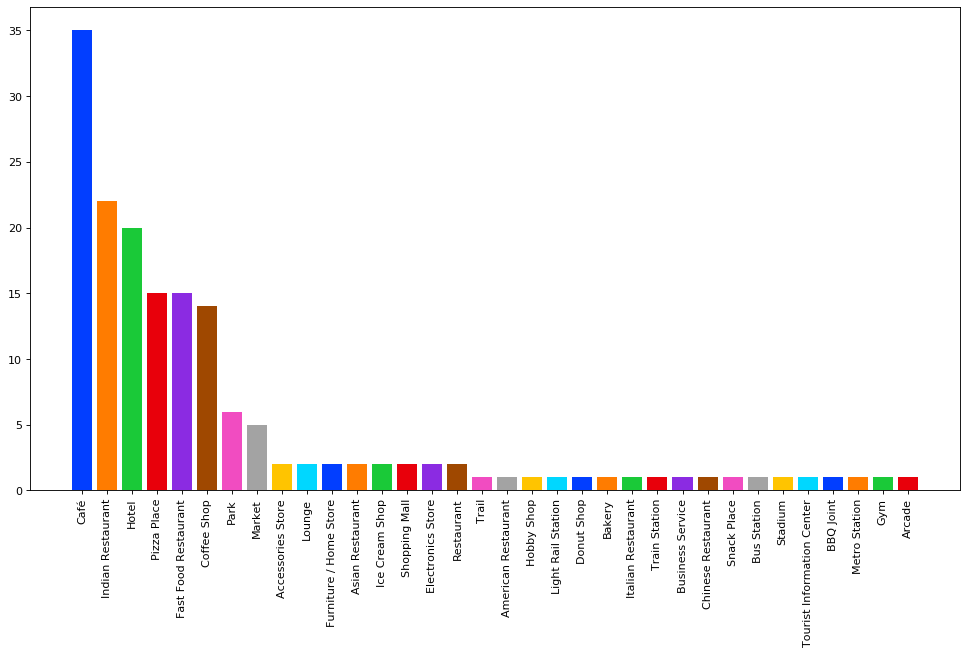

In [85]:
plt.figure(figsize = (15, 8), dpi = 80)
plt.bar(X, y, color = colors)
plt.xticks(rotation = 'vertical')
plt.savefig(desktop +'extras/top-venue-bar.png', bbox_inches = 'tight')

### Here's how New Delhi Neighborhoods(colored circles) and their disticts(each color representing a different district) looks

In [84]:
delhi_map

### Getting the best Neighborhoods for popular shops in New Delhi and gathering the price of each Neighborhood


In [86]:
cafe_data = get_best_markets('Café')

In [87]:
cafe_data.head()

,Neighborhoods,NumCafé,Prices
0,Dhaula Kuan,7.0,NaN
1,Uttam Nagar,7.0,7486.00
2,Mehrauli,7.0,12612.03
3,Preet Vihar,6.0,35433.03
4,New Friends Colony,6.0,12636.03


In [251]:
cafe_data.groupby('NumCafé').mean()

,Prices
NumCafé,
1.0,9814.172222
2.0,10016.991304
3.0,13420.554138
4.0,13618.876897
5.0,18473.400000
6.0,20064.051429
7.0,10049.015000


In [88]:
coffeeshop_data = get_best_markets('coffee shop')

In [89]:
coffeeshop_data.sort_values('Prices').head(10)

,Neighborhoods,NumCoffee Shop,Prices
84,Maharani Bagh,2.0,115.23
12,Kamla Nagar,5.0,293.63
52,Mahipalpur,3.0,540.75
32,Timarpur,4.0,916.39
46,Rajender Nagar,3.0,931.82
42,Pandav Nagar,3.0,1457.06
66,Golf Links,2.0,2845.53
90,Khan Market,2.0,2845.53
83,Nehru Nagar,2.0,2921.35
39,Sainik Farm,3.0,2962.96


In [90]:
neigh_price_df_final.sort_values('Prices(sqft)', ascending = False).head(10)

,Neighborhoods,Latitudes,Longitudes,Prices(sqft)
167,Greater kailash enclave II,NaN,NaN,103591.16
40,Sector 10 Dwarka,28.56188,77.05736,102339.42
32,Sector 23 Dwarka,28.58444,77.05902,85241.30
706,Pontoon Bridge,NaN,NaN,80000.00
330,Malka Ganj,28.67722,77.20921,77564.10
8,Vasant Kunj,28.53152,77.15021,68576.87
562,Pind Wala Khurd Village,NaN,NaN,65573.77
12,Panchsheel Park,28.54287,77.21457,60449.23
24,Kalkaji,28.53662,77.26094,57796.75
441,Defence Colony Flyover,28.58252,77.01031,53722.18


In [91]:
bakery_data = get_best_markets('bakery')

In [92]:
bakery_data.sort_values('NumBakery', ascending = False).head(10)

,Neighborhoods,NumBakery,Prices
0,South Extension,3.0,34953.84
2,Sarojini Nagar,3.0,4526.75
3,Gulmohar Park,3.0,24418.68
4,Model Town,3.0,13747.54
1,Chittaranjan Park,3.0,20944.52
12,Munirka,2.0,15383.25
19,Daryaganj,2.0,9272.73
18,East of Kailash,2.0,14927.57
17,Greater Kailash,2.0,42582.15
16,Hauz Khas Village,2.0,21539.83


In [97]:
coffeeshop_data.groupby('NumCoffee Shop').mean()

,Prices
NumCoffee Shop,
1.0,12305.84000
2.0,17083.72697
3.0,12116.94381
4.0,18616.61250
5.0,12277.17000
6.0,6726.35750
7.0,NaN
8.0,9726.40000


In [ ]:
#Saving the html file locally
# with open(desktop + 'RealEstateHtml.txt', 'w') as file:
#     text = str(bs).encode('utf-8')
#     file.write(str(text))